In [1]:
%matplotlib inline
import random
import csv
import sys
import os
import re
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import scipy as sp
import sklearn
import operator
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.cluster import MeanShift
from sklearn.cluster import estimate_bandwidth
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import sklearn.metrics as metrics
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy.sparse import issparse

/Users/zhjin/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def row_norms(X, squared=False):
    """Row-wise (squared) Euclidean norm of X.
    Equivalent to np.sqrt((X * X).sum(axis=1)), but also supports sparse
    matrices and does not create an X.shape-sized temporary.
    Performs no input validation.
    """
    if issparse(X):
        if not isinstance(X, csr_matrix):
            X = csr_matrix(X)
        norms = csr_row_norms(X)
    else:
        norms = np.einsum('ij,ij->i', X, X)

    if not squared:
        np.sqrt(norms, norms)
    return norms

def _k_init(X, n_clusters, x_squared_norms, random_state, n_local_trials=None):
    """Init n_clusters seeds according to k-means++
    Parameters
    -----------
    X : array or sparse matrix, shape (n_samples, n_features)
        The data to pick seeds for. To avoid memory copy, the input data
        should be double precision (dtype=np.float64).
    n_clusters : integer
        The number of seeds to choose
    x_squared_norms : array, shape (n_samples,)
        Squared Euclidean norm of each data point.
    random_state : numpy.RandomState
        The generator used to initialize the centers.
    n_local_trials : integer, optional
        The number of seeding trials for each center (except the first),
        of which the one reducing inertia the most is greedily chosen.
        Set to None to make the number of trials depend logarithmically
        on the number of seeds (2+log(k)); this is the default.
    Notes
    -----
    Selects initial cluster centers for k-mean clustering in a smart way
    to speed up convergence. see: Arthur, D. and Vassilvitskii, S.
    "k-means++: the advantages of careful seeding". ACM-SIAM symposium
    on Discrete algorithms. 2007
    Version ported from http://www.stanford.edu/~darthur/kMeansppTest.zip,
    which is the implementation used in the aforementioned paper.
    """
    n_samples, n_features = X.shape

    centers = np.empty((n_clusters, n_features), dtype=X.dtype)

    assert x_squared_norms is not None, 'x_squared_norms None in _k_init'

    # Set the number of local seeding trials if none is given
    if n_local_trials is None:
        # This is what Arthur/Vassilvitskii tried, but did not report
        # specific results for other than mentioning in the conclusion
        # that it helped.
        n_local_trials = 2 + int(np.log(n_clusters))

    # Pick first center randomly
    center_id = random_state.randint(n_samples)
    if sp.issparse(X):
        centers[0] = X[center_id].toarray()
    else:
        centers[0] = X[center_id]

    # Initialize list of closest distances and calculate current potential
    closest_dist_sq = euclidean_distances(
        centers[0, np.newaxis], X, Y_norm_squared=x_squared_norms,
        squared=True)
    current_pot = closest_dist_sq.sum()

    # Pick the remaining n_clusters-1 points
    for c in range(1, n_clusters):
        # Choose center candidates by sampling with probability proportional
        # to the squared distance to the closest existing center
        rand_vals = random_state.random_sample(n_local_trials) * current_pot
        candidate_ids = np.searchsorted(stable_cumsum(closest_dist_sq),
                                        rand_vals)

        # Compute distances to center candidates
        distance_to_candidates = euclidean_distances(
            X[candidate_ids], X, Y_norm_squared=x_squared_norms, squared=True)

        # Decide which candidate is the best
        best_candidate = None
        best_pot = None
        best_dist_sq = None
        for trial in range(n_local_trials):
            # Compute potential when including center candidate
            new_dist_sq = np.minimum(closest_dist_sq,
                                     distance_to_candidates[trial])
            new_pot = new_dist_sq.sum()

            # Store result if it is the best local trial so far
            if (best_candidate is None) or (new_pot < best_pot):
                best_candidate = candidate_ids[trial]
                best_pot = new_pot
                best_dist_sq = new_dist_sq

        # Permanently add best center candidate found in local tries
        if sp.issparse(X):
            centers[c] = X[best_candidate].toarray()
        else:
            centers[c] = X[best_candidate]
        current_pot = best_pot
        closest_dist_sq = best_dist_sq

    return centers

class SLIC:
    """
    Segments image and other sensor datasets with geospatial properties using k-means clustering.
        Parameters
        ----------
        matrix : nD ndarray
            Input matrix, which has (latitute, longitute, f1, f2, f3....)
            where f1, f2, f3 are features other than geospatial data.
            Here we denote them as sensor data.
        n_clusters : int, optional
            The (approximate) number of labels in the segmented output image.
        compactness : float, optional
            Balances sensor data proximity and space proximity. Higher values give
            more weight to space proximity, making superpixel shapes more
            square/cubic. In SLICO mode, this is the initial compactness.
            This parameter depends strongly on image contrast and on the
            shapes of objects in the image. We recommend exploring possible
            values on a log scale, e.g., 0.01, 0.1, 1, 10, 100, before
            refining around a chosen value.
        max_iter : int, optional
            Maximum number of iterations of k-means.
    """
    
    def __init__(self, n_clusters=100, compactness=10., max_iter=10):
        self.n_clusters = n_clusters
        self.compactness = compactness
        self.max_iter = max_iter

    def fit_predict(self, X):
        # Step 1, initialize cluster centers
        x_squared_norms = row_norms(X, squared=True)
        centroids = _k_init(X, self.n_clusters, x_squared_norms, np.random.RandomState)
        print centroids

# Roadmap
Stage1: Researched and selected which clustering algorithm to apply on the wind data. Surveryed algorithms like k-means, agglomerative clustering, spectral_clustering, etc. Choose k-means as the best one to apply.

Stage2: Researched about how to determine the number of clusters to use in the k-means algorithm. Researched many online papers and references, and decided to use gap statistic implementation to find the optimal number of culsters.

Stage3: Gap statistic doesn't give clear winner for our data. Implemented a two stage clustering algorithm to address this issue. However, gap statistic still fails in some cases.

Stage4: Deborah suggested that the data could be biased. Switched to Easter_Cape_Cod_MA and Western_Cape_Cod_MA data for analysis. Two stage gap statistic gives satisfying results.

Stage5: Wrote database connection tool to attempt to read large amount of wind farm data. Need to build an index to do this.

Stage6: Due to big data, need to reduce the number of features and also increase the runtime of the two stage clustering algorithm. 

Stage7: Due to the instability(not always able to find the optimal number of clusters) of the two-stage gap statistic algorithm and its super slow run time, researched again and switched to silhouette score method. This method is guarenteed to find the optimal number of clusters and has significantly better runtime. In addition, researched and imlemented principle component analysis with singular vector decomposition to reduce the dimension of the capacity feature vectors.

# Final Algorithm

Step1: Load the matrix.

Step2: Select the best k from SVD only for the capacity features. k is the reduced capactity feature vector dimensions.

Step3: Run PCA to reduce the number of features using k.

Step4: Run silhouette analysis to determine the optimal number of clusters.

Step5: Run kmeans on the optimal number of culsters to produce the final result.

In [ ]:
def preprocess(path = "./wind_capacity_factors_months_2_5_8.csv"):
    """
    A helper method
    pre-procss the data
    returns a dictionary of wind_point_id -> features
    the first two features is lat and lon, and the rest is all the capacity factors
    """
    
    # attributes = ['hour', 'wind_point_id', 'avg(capacity_factor)', 'lon', 'month', 'year', 'lat', 'day']
    # Load the wind CSV file
    windFile = path
    input_train_file = csv.DictReader(open(windFile))
    
    wind_point_dictionary = {}

    for row in input_train_file:
        wind_point_id = row['wind_point_id']
        features = []
        # we've added this point previously, so we just append the feature:
        if wind_point_id in wind_point_dictionary:
            features = wind_point_dictionary[wind_point_id]
            features.append(float(row['avg(capacity_factor)']))
            pass
        # we've not seen this point before:
        else:
            features.append(float(row['lat']))
            features.append(float(row['lon']))
            features.append(float(row['avg(capacity_factor)']))
        # update the dictionary
        wind_point_dictionary[wind_point_id] = features
    
    return wind_point_dictionary

def preprocess2(folder_name = "Easter_Cape_Cod_MA") :
    '''
    Folder contains many csv files. Each csv file contains capacity factors of a wind point.
    preprocess2 returns a list of position of each wind point and wind point dictionary whose key is a site id 
    and value is a list consisting of the position(lat, lon) and the averages of capacity factors of each hour. 
    '''
    wind_point_dictionary = {}
    match = r".+\.csv"
    for root, subdirs, files in os.walk("./" + folder_name):
        for filename in files:
            # To check if the file is in the format of csv or not
            if (re.match(match, filename) != None) :
                features = []
                file_path = os.path.join(root, filename)
                # Open each file, create a list of features of a wind_point and add it to wind_point_dictionary(dictionary)
                # Also, create a list named position and append it to positions(list)
                with open(file_path, 'r') as f:
                    f_contents = f.readlines()
                    for counter, line in enumerate(f_contents) :
                        if (counter == 0) :
                            # store wind point id to a variable (later, it will be a key for dictionary)
                            wind_point_id = float(line.strip().split(",")[-1])
                        elif (counter == 1) :
                            # store longitude to a variable (to append lat and lon in order)
                            lon = float(line.strip().split(",")[-1])
                        elif (counter == 2) :
                            # append lat to features
                            lat = float(line.strip().split(",")[-1])
                            features.append(lat)
                        elif (counter == 3) :
                            # append lon to features and position. skip 4th row since it's just the names of columns 
                            features.append(lon)
                            pass
                        elif ((counter - 4) % 12 == 0) :
                            # append the first "minute" of an hour 
                            features.append(float(line.strip().split(",")[-1]))
                        elif ((counter - 4) % 12 == 11) :
                            # add the last "minute" of an hour and divide it by 12 to find the average
                            features[-1] += float(line.strip().split(",")[-1])
                            features[-1] /= 12
                        else :
                            # add 2nd to 11th "minutes" of an hour
                            features[-1] += float(line.strip().split(",")[-1])
                    max_capacity = np.max(features[2:])
                    for i in range(len(features)):
                        if i >= 2:
                            features[i] = features[i] / max_capacity
                    wind_point_dictionary[wind_point_id] = features
                    f.close()
    return wind_point_dictionary

def preprocess3(folder_name = "Easter_Cape_Cod_MA") :
        '''
        Folder contains many csv files. Each csv file contains position and capacity factors of a wind point.
        preprocess returns a list of position lists of every wind points as well as 
        a list of capacity lists which consists of capacities for every two hours
        positions = [[-40, 50], [-45, 39] ... ]
        capacities = [[20, 22, 25, 30, 25, 19], [20, 20, 22, 22, 20, 21] ... ]
        '''
        capacities = []
        positions = []
        match = r".+\.csv"
        for root, subdirs, files in os.walk("./" + folder_name):
            for filename in files:
                # To check if the file is in the format of csv or not
                if (re.match(match, filename) != None) :
                    file_path = os.path.join(root, filename)
                    # Open each file, create a list of features of a wind_point and add it to wind_point_dictionary(dictionary)
                    # Also, create a list named position and append it to positions(list)
                    with open(file_path, 'r') as f:
                        f_contents = f.readlines()
                        capacity = []
                        position = []
                        for counter, line in enumerate(f_contents) :
                            if (counter == 0) :
                                # Line 0 : SiteID - we don't need SiteID
                                pass 
                            elif (counter == 1) :
                                # Line 1 : Longitude - store longitude to a variable (to append lat and lon in order later)
                                lon = float(line.strip().split(",")[-1])
                            elif (counter == 2) :
                                # Line 2 : Latitude - store latitude to a variable and append it to position
                                lat = float(line.strip().split(",")[-1])
                                position.append(lat)
                            elif (counter == 3) :
                                # Line 3 : Column names - Now that we have lat and lon, append lon to position. 
                                # Skip Line 3 since it's just the names of columns 
                                position.append(lon)
                                pass
                            elif ((counter - 4) % 24 == 0) :
                                # append the first "minute" of two hours 
                                capacity.append(float(line.strip().split(",")[-1]))
                            elif ((counter - 4) % 24 == 23) :
                                # add the last "minute" of two hours and divide it by 24 to find the average
                                capacity[-1] += float(line.strip().split(",")[-1])
                                capacity[-1] /= 24
                            else :
                                # add 2nd to 23th "minutes" of two hours
                                capacity[-1] += float(line.strip().split(",")[-1])
                        max_capacity = np.max(capacity)
                        positions.append(position)
                        capacities.append(capacity / max_capacity)
                        f.close()

        return (np.array(positions), np.array(capacities))
    

def preprocess4(folder_name = "Easter_Cape_Cod_MA") :
    '''
    Folder contains many csv files. Each csv file contains capacity factors of a wind point.
    preprocess2 returns a list of position of each wind point and wind point dictionary whose key is a site id 
    and value is a list consisting of the position(lat, lon) and the averages of capacity factors of each hour. 
    '''
    capacities = []
    positions = []
    match = r".+\.csv"
    for root, subdirs, files in os.walk("./" + folder_name):
        for filename in files:
            # To check if the file is in the format of csv or not
            if (re.match(match, filename) != None) :
                features = []
                file_path = os.path.join(root, filename)
                # Open each file, create a list of features of a wind_point and add it to wind_point_dictionary(dictionary)
                # Also, create a list named position and append it to positions(list)
                with open(file_path, 'r') as f:
                    f_contents = f.readlines()
                    capacity = []
                    position = []
                    for counter, line in enumerate(f_contents) :
                        if (counter == 0) :
                            # store wind point id to a variable (later, it will be a key for dictionary)
                            wind_point_id = float(line.strip().split(",")[-1])
                        elif (counter == 1) :
                            # store longitude to a variable (to append lat and lon in order)
                            lon = float(line.strip().split(",")[-1])
                        elif (counter == 2) :
                            # append lat to features
                            lat = float(line.strip().split(",")[-1])
                            position.append(lat)
                        elif (counter == 3) :
                            # append lon to features and position. skip 4th row since it's just the names of columns 
                            position.append(lon)
                            pass
                        elif ((counter - 4) % 12 == 0) :
                            # append the first "minute" of an hour 
                            capacity.append(float(line.strip().split(",")[-1]))
                        elif ((counter - 4) % 12 == 11) :
                            # add the last "minute" of an hour and divide it by 12 to find the average
                            capacity[-1] += float(line.strip().split(",")[-1])
                            capacity[-1] /= 12
                        else :
                            # add 2nd to 11th "minutes" of an hour
                            capacity[-1] += float(line.strip().split(",")[-1])
                    max_capacity = np.max(capacity)
                    positions.append(position)
                    capacities.append(capacity / max_capacity)
                    f.close()
    return (np.array(positions), np.array(capacities))

def normalization(matrix):
    return matrix
    """
    normalized_matrix = np.zeros((matrix.shape[0], matrix.shape[1]))
    mean = np.mean(matrix, axis=0)
    sd = np.std(matrix, axis=0)
    for i in range(normalized_matrix.shape[0]):
        normalized_matrix[i] = (matrix[i] - mean) / sd
    for i in range(normalized_matrix.shape[0]):
        for j in range(normalized_matrix.shape[1]):
            if np.isnan(normalized_matrix[i][j]):
                normalized_matrix[i][j] = 0
    return normalized_matrix
    """
    

def load_design_matrix(preprocess_f, path):
    """
    call this method to load the entire data matrix
    preprocess_f: the function of the preprocessing method
    path: the file path or folder to be used for the preprocess method.
    """
    wind_point_dictionary = preprocess_f(path)
    # next step: build the design matrix
    matrix = None
    positions = None

    for key in wind_point_dictionary.keys() :
        features = np.copy(wind_point_dictionary[key]) 
        #features = featureEngineering(features)
        position = np.copy(wind_point_dictionary[key][:2])
        if matrix is None:
            matrix = np.array([features])
            positions = np.array([position])
        else:
            matrix = np.append(matrix, [features], axis = 0)
            positions = np.append(positions, [position], axis = 0)
    
    #matrix = normalization(matrix)
    
    return (positions, matrix)

def load_geo_matrix(preprocess_f, path):
    """
    call this method to load the geographic matrix (only contains longitude and latitude)
    """
    wind_point_dictionary = preprocess_f(path)
    # next step: build the geo matrix
    matrix = None
    positions = None

    for key in wind_point_dictionary.keys() :
        features = np.copy(wind_point_dictionary[key][:2]) 
        #features = featureEngineering(features)
    
        if matrix is None:
            matrix = np.array([features])
            positions = np.array([features])
        else:
            matrix = np.append(matrix, [features], axis = 0)
            positions = np.append(positions, [features], axis = 0)
            
    #matrix = normalization(matrix)
    
    return (positions, matrix)

def load_capacity_matrix(preprocess_f, path):
    """
    call this method to load the geographic matrix (only contains longitude and latitude)
    """
    wind_point_dictionary = preprocess_f(path)
    # next step: build the geo matrix
    matrix = None
    positions = None

    for key in wind_point_dictionary.keys() :
        features = np.copy(wind_point_dictionary[key][2:]) 
        #features = featureEngineering(features)
        position = np.copy(wind_point_dictionary[key][:2])
        if matrix is None:
            matrix = np.array([features])
            positions = np.array([position])
        else:
            matrix = np.append(matrix, [features], axis = 0)
            positions = np.append(positions, [position], axis = 0)
            
    #matrix = normalization(matrix)
    
    return (positions, matrix)

def load_PCA_design_matrix(preprocess_f, path, d):
    """
    Generate a design matrix such that the capacity feature dimensions
    are reduced using PCA and the distance dimensions(lat and lon) are 
    preserved.
    d: the dimension of the reduced space.
    """
    capacity_positions, capacity_matrix = load_capacity_matrix(preprocess_f, path)
    pca = PCA(n_components=d)
    # X is the matrix transposed (n samples on the rows, m features on the columns)
    reduced_capacity_matrix = pca.fit_transform(capacity_matrix)
    reduced_design_matrix = np.zeros((reduced_capacity_matrix.shape[0], reduced_capacity_matrix.shape[1] + 2))
    for i in range(reduced_design_matrix.shape[0]):
        reduced_design_matrix[i][0] = capacity_positions[i][0]
        reduced_design_matrix[i][1] = capacity_positions[i][1]
        for j in range(2, reduced_design_matrix.shape[1]):
            reduced_design_matrix[i][j] = reduced_capacity_matrix[i][j-2]
    return (capacity_positions, reduced_design_matrix, reduced_capacity_matrix)


def PCA_dimension_selection(matrix, variance_threshold):
    """
    Given a matrix, find the smallest k such that the variance threshold is retained
    """
    U, s, V = np.linalg.svd(matrix, full_matrices=False)
    S = np.diag(s)
    summation = 0.0
    # Step 1, calculate the denominator.
    for i in range(S.shape[0]):
        summation += S[i][i]
    k_array = []
    # Step 2, use dynamic programming to calculate the cumulating k
    for k in range(S.shape[0]):
        if k == 0:
            k_array.append(S[k][k])
        else:
            k_array.append(k_array[k-1] + S[k][k])
        if k_array[k] / summation >= variance_threshold:
            return k
    return S.shape[0]

    

def plot_design_matrix(position, design_matrix):
    plt.figure(figsize=(20,20))
    plt.legend(loc=2,fontsize = 'xx-large')

    plt.scatter(position[:,0], position[:,1], c='blue', s=75, alpha = 0.6, label = "true wind point")

    plt.grid(True)
    plt.legend(loc='upper right')
    plt.xlabel("latitude")
    plt.ylabel("longitude")

    plt.show()
    
def silhouette_analysis(positions, design_matrix, visualizeCenter):
    """Visualize the center only if doing geospecial clustering."""
    silhouette_avg_map = {}
    sqrt = int(np.sqrt(design_matrix.shape[0]))
    for n_clusters in range(2, min(int(2 * sqrt), design_matrix.shape[0])):
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(design_matrix) + (n_clusters + 1) * 10])
        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(design_matrix)
        # clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', affinity='euclidean')
        # cluster_labels = clusterer.fit_predict(design_matrix)
        # clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', affinity='euclidean')
        # cluster_labels = clusterer.fit_predict(design_matrix)
        #clusterer = SpectralClustering(n_clusters=n_clusters,
        #                        eigen_solver="arpack",
        #                        affinity="rbf")
        cluster_labels = clusterer.fit_predict(design_matrix)
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(design_matrix, cluster_labels)
        silhouette_avg_map[n_clusters] = silhouette_avg
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)
            # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(design_matrix, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(positions[:, 0], positions[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors)

        if visualizeCenter:
            # Labeling the clusters
            centers = clusterer.cluster_centers_
            # Draw white circles at cluster centers
            ax2.scatter(centers[:, 0] / 1000, centers[:, 1] / 1000,
                        marker='o', c="white", alpha=1, s=200)

            for i, c in enumerate(centers):
                ax2.scatter(c[0] / 1000, c[1] / 1000, marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()
    # Return the highest scoring n_clusters
    optimal_n_clusters = max(silhouette_avg_map.iteritems(), key=operator.itemgetter(1))[0]
    print("Optimal n_clusters =", optimal_n_clusters,
        "The average silhouette_score is :", silhouette_avg_map[optimal_n_clusters])
    return optimal_n_clusters

def plot(positions, design_matrix, visualizeCenter):
    
    bandwidth = estimate_bandwidth(design_matrix, quantile=0.3, n_samples=100)
    print ("bandwidth: ", bandwidth)
    clusterer = MeanShift(10, bin_seeding=True)
    cluster_labels = clusterer.fit_predict(design_matrix)
    centers = clusterer.cluster_centers_
    n_clusters = len(centers)
    
    
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    plt.scatter(positions[:, 0], positions[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors)
    
    if visualizeCenter:
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0] / 1000, centers[:, 1] / 1000,
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0] / 1000, c[1] / 1000, marker='$%d$' % i, alpha=1, s=50)

    plt.xlabel("Feature space for the 1st feature")
    plt.ylabel("Feature space for the 2nd feature")

    plt.title(("Meanshift clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()
    

def capacity_timeseries_visualization():
    positions, capacities = preprocess3("Easter_Cape_Cod_MA")
    processed_capacities = []
    for i in range(capacities.shape[0]):
        row = capacities[i]
        array = []
        for j in range(row.shape[0]):
            if j % 360 == 0:
                for k in range(j, j+11):
                    array.append(row[k])
        processed_capacities.append(array)
    return (positions, np.array(processed_capacities))
    
    

def main(preprocess_f, path):
    """
    A full run of the algorithm.
    Step1: Load the matrix.
    Step2: Select the best k from SVD only for the capacity features. k is the reduced capactity feature vector dimensions.
    Step3: Run PCA to reduce the number of features using k.
    Step4: Run silhouette analysis to determine the optimal number of clusters.
    Step5: Run kmeans on the optimal number of culsters to produce the final result.
    """
    # Step 1
    variance_threshold = 0.90
    capacity_positions, capacity_matrix = load_capacity_matrix(preprocess_f, path)
    # Step 2
    optimal_k = PCA_dimension_selection(capacity_matrix, variance_threshold)
    print("The original capacity feature dimension is: ", capacity_matrix.shape[1],
          " The optimal reduced dimension from SVD is: ", optimal_k, 
          " The variance retained is: ", variance_threshold)
    # Step 3
    reduced_design_matrix_positions, reduced_design_matrix, reduced_capacity_matrix = load_PCA_design_matrix(preprocess_f, path, optimal_k)
    print "The reduced design matrix is: "
    print reduced_design_matrix
    # Step 4
    optimal_n_clusters = silhouette_analysis(reduced_design_matrix_positions, reduced_design_matrix, visualizeCenter=False)
    # Step 5
    clusterer = KMeans(n_clusters=9, random_state=10)
    cluster_labels = clusterer.fit_predict(reduced_design_matrix)
    return cluster_labels

def capacity_clustering(preprocess_f, path):
    # Step 1
    positions, capacity_matrix = preprocess_f(path)
    # Step 2
    optimal_n_clusters = silhouette_analysis(positions, capacity_matrix, visualizeCenter=False)
    # Step 3
    clusterer = KMeans(n_clusters=11, random_state=10)
    cluster_labels = clusterer.fit_predict(capacity_matrix)
    return cluster_labels

def general_rmse(matrix, labels):
    """
    Given a wind point data matrix and the clustering labels,
    calculate the root mean square error of the clustering.
    """
    clusters = {}
    # First Pass
    # group wind points to their perspective clusters
    for i in range(len(labels)):
        cluster_num = labels[i]
        wind_point = np.copy(matrix[i])

        if cluster_num not in clusters:
            members = []
            members.append(wind_point)
            clusters[cluster_num] = members
        else:
            members = clusters[cluster_num]
            members.append(wind_point)
            clusters[cluster_num] = members


    clusters_rmse = 0
    # Second Pass, calculate the mean point and the rmse 
    for cluster_num in clusters:
        cluster = np.array(clusters[cluster_num])
        center = np.mean(cluster, axis=0)
        # make it a column vector instead of a row vector
        center.shape = (center.shape[0], 1)
    
        for point in cluster:
            # make it a column vector instead of a row vector
            point.shape = (point.shape[0], 1)
            rmse = np.linalg.norm(point - center)
            clusters_rmse += rmse

    return clusters_rmse
    

def hyper_parameter_testing(preprocess_f, path, original_matrix):
    #original_matrix = load_design_matrix(preprocess_f, path)[1]
    # Make a copy
    input_matrix = np.zeros(original_matrix.shape)
    input_matrix[:,:] = original_matrix[:,:]
    # Some parameters
    min_n_clusters = 2
    max_n_clusters = min(100, input_matrix.shape[0] - 5)
    step = 5
    weight_array = [i*10 for i in range(1, 50, 5)]
    color_map = iter(cm.rainbow(np.linspace(0,1,len(weight_array))))
    variance_threshold = 0.90 # for PCA
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)
    # iterate through the weights
    
    for weight in weight_array:
        # Apply the weight to the capacity factors
        input_matrix[:,2:] = input_matrix[:,2:] * weight
        capacity_matrix = input_matrix[:,2:]
        # Do PCA
        n_components = PCA_dimension_selection(capacity_matrix, variance_threshold)
        pca = PCA(n_components=n_components)
        reduced_capacity_matrix = pca.fit_transform(capacity_matrix)
        # reconstruct the input matrix
        input_matrix = np.zeros((reduced_capacity_matrix.shape[0], reduced_capacity_matrix.shape[1] + 2))
        input_matrix[:,:2] = original_matrix[:,:2]
        input_matrix[:,2:] = reduced_capacity_matrix[:,:]

        rmse_kmeans = []
        n_clusters = []
        # iterate through the number of clusters
        for n_cluster in range(2, 10):
            print "Calculating...weight=" + str(weight) + " n_cluster=" + str(n_cluster)
        # Perform kmeans
            kmeans = KMeans(n_clusters=n_cluster, random_state=0, max_iter=500, n_init = 40)
            kmeans_labels = kmeans.fit_predict(input_matrix)
            rmse_kmeans.append(general_rmse(original_matrix, kmeans_labels))
            n_clusters.append(n_clusters)
        print (len(rmse_kmeans), len(n_clusters))
        #print "I am here"
        #c = next(color_map)
        #print "plotting"
        plt.plot(n_clusters, rmse_kmeans, c="black", alpha=0.7)
        #plt.show()
        #print "plotting"
        #fig.plot(n_clusters, rmse_kmeans, c=c, label = "weight = " + str(weight), alpha=0.7)
        #print "finish plotting"

    plt.title("Comparative Analysis")
    plt.ylabel("Root Mean Square Error")
    plt.xlabel("n_clusters")
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.show()
    

In [7]:
original_matrix = load_design_matrix(preprocess2, "Easter_Cape_Cod_MA")[1]

In [ ]:
original_matrix

In [ ]:
hyper_parameter_testing(preprocess2, "Easter_Cape_Cod_MA", original_matrix)

In [345]:
#main(preprocess, "./wind_capacity_factors_months_2_5_8.csv")

('For n_clusters =', 2, 'The average silhouette_score is :', 0.52965424804538619)


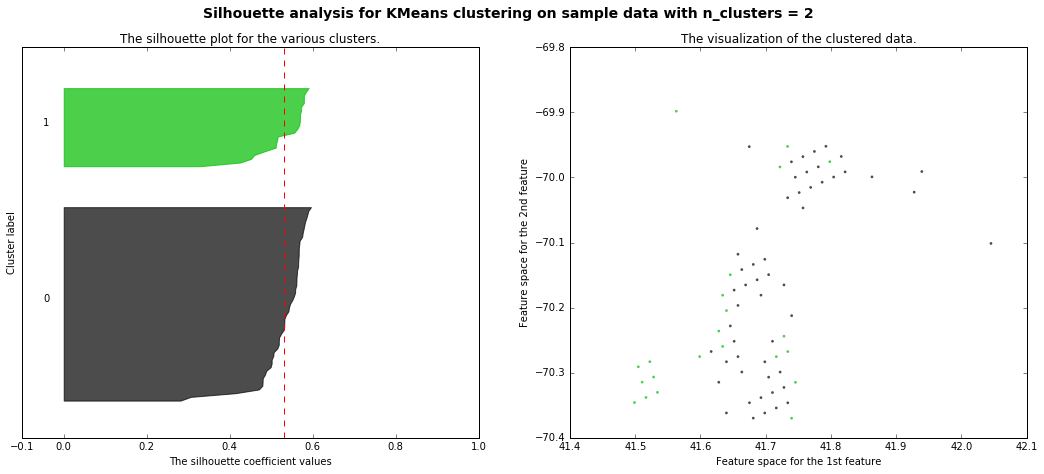

('For n_clusters =', 3, 'The average silhouette_score is :', 0.33357222922987634)


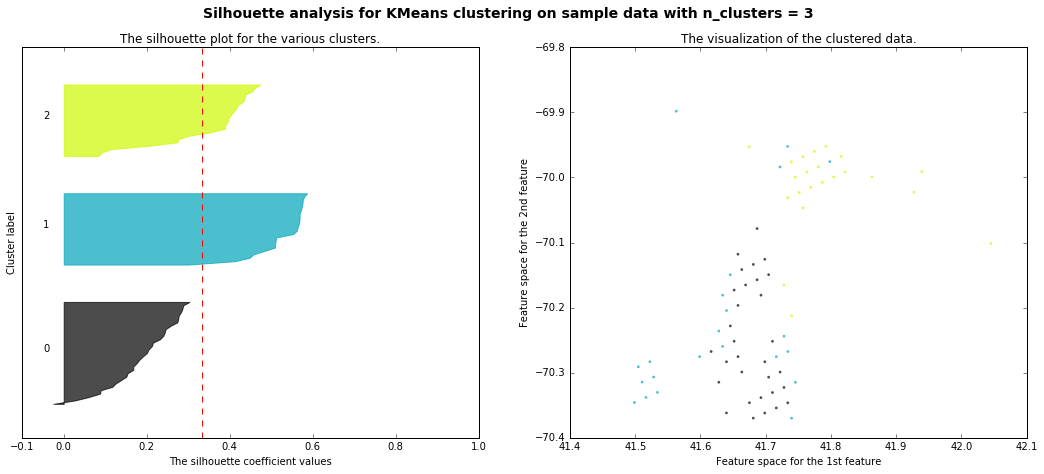

('For n_clusters =', 4, 'The average silhouette_score is :', 0.36123673632225406)


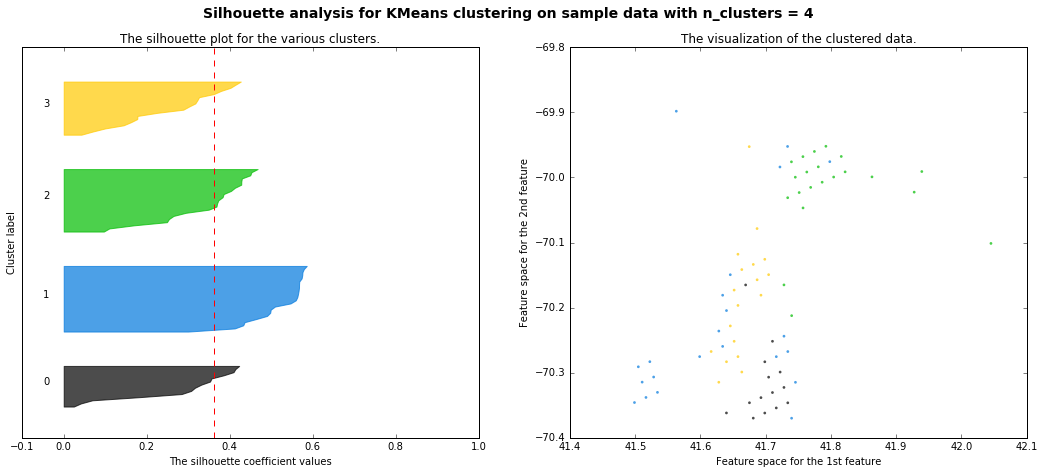

('For n_clusters =', 5, 'The average silhouette_score is :', 0.32057435741732648)


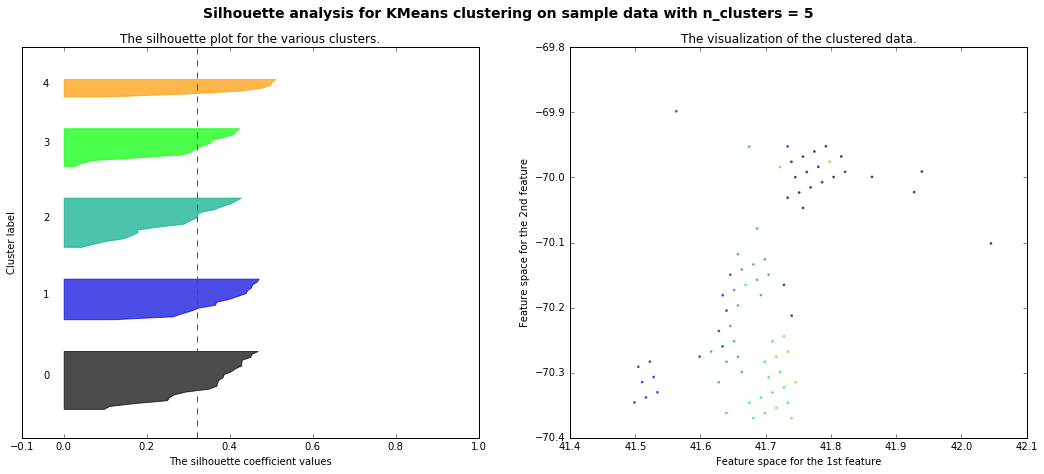

('For n_clusters =', 6, 'The average silhouette_score is :', 0.30087143743130468)


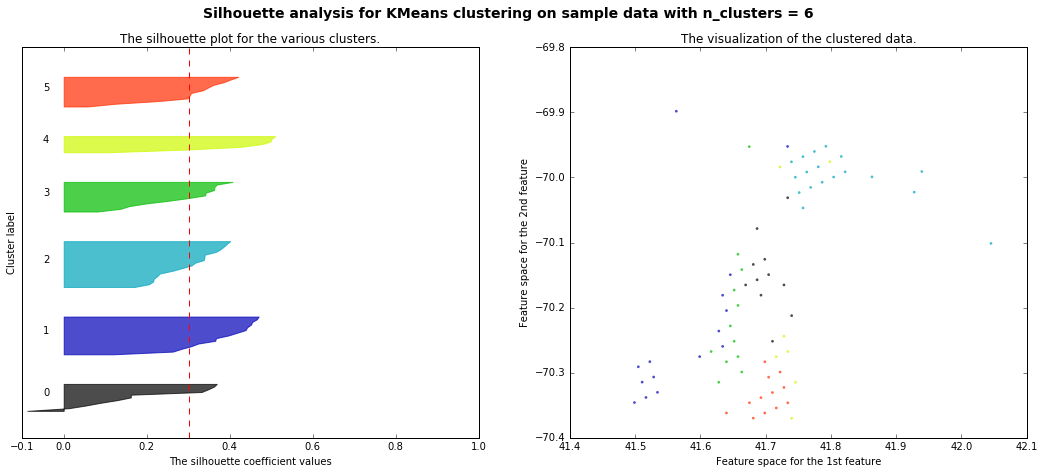

('For n_clusters =', 7, 'The average silhouette_score is :', 0.30990724175439782)


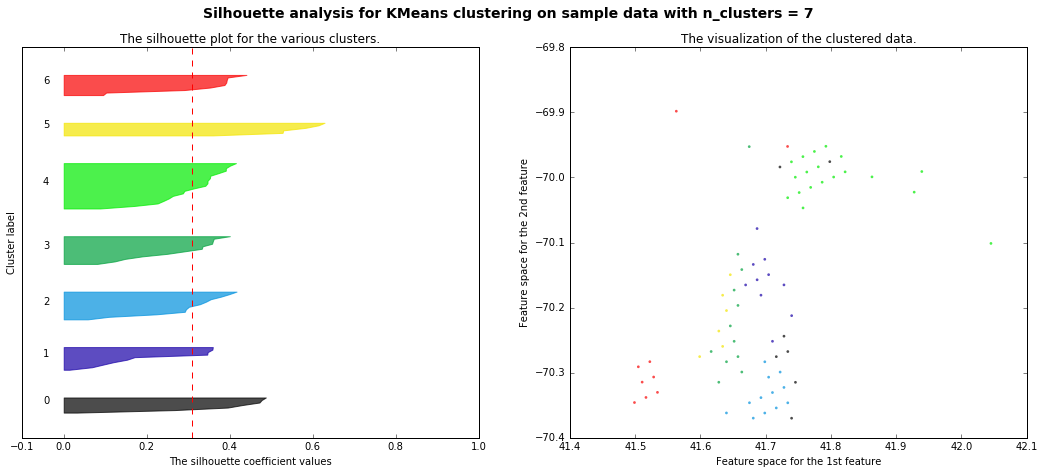

('For n_clusters =', 8, 'The average silhouette_score is :', 0.32469028078043444)


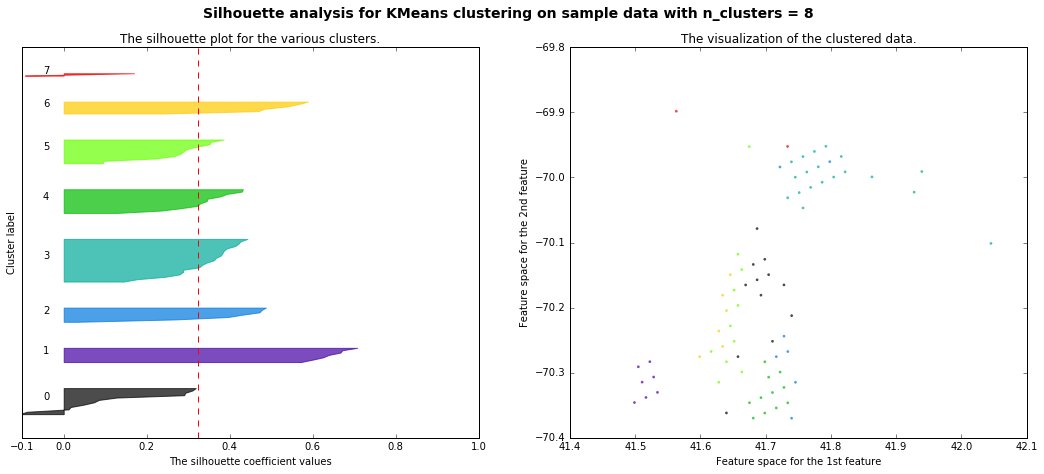

('For n_clusters =', 9, 'The average silhouette_score is :', 0.32312019376842693)


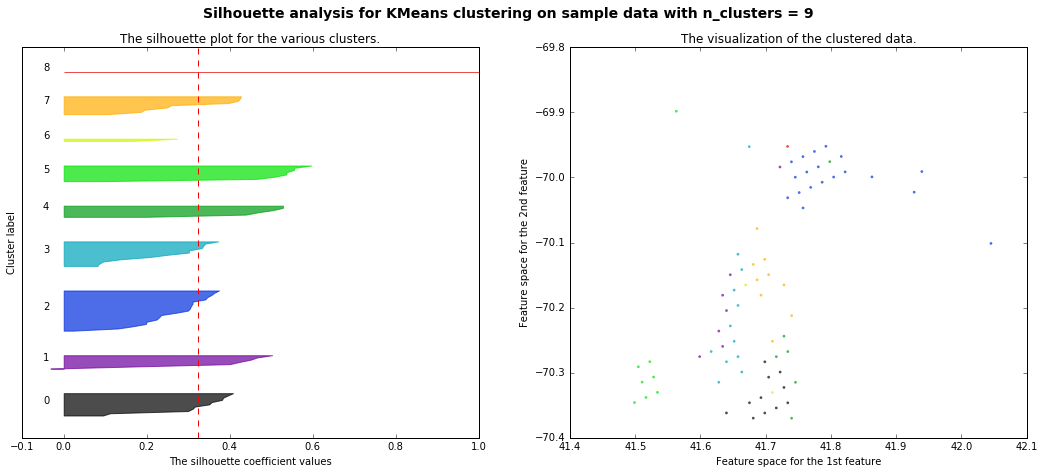

('For n_clusters =', 10, 'The average silhouette_score is :', 0.30566703172383181)


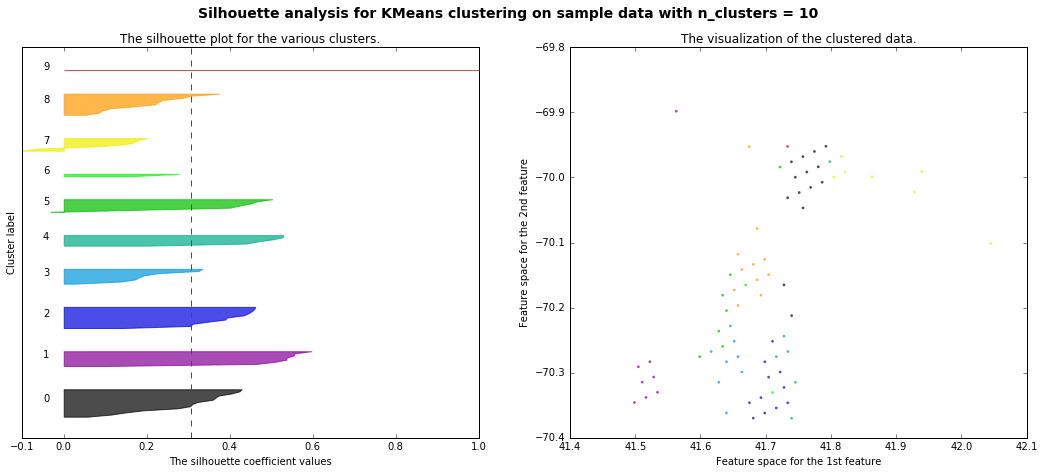

('For n_clusters =', 11, 'The average silhouette_score is :', 0.32876482854718536)


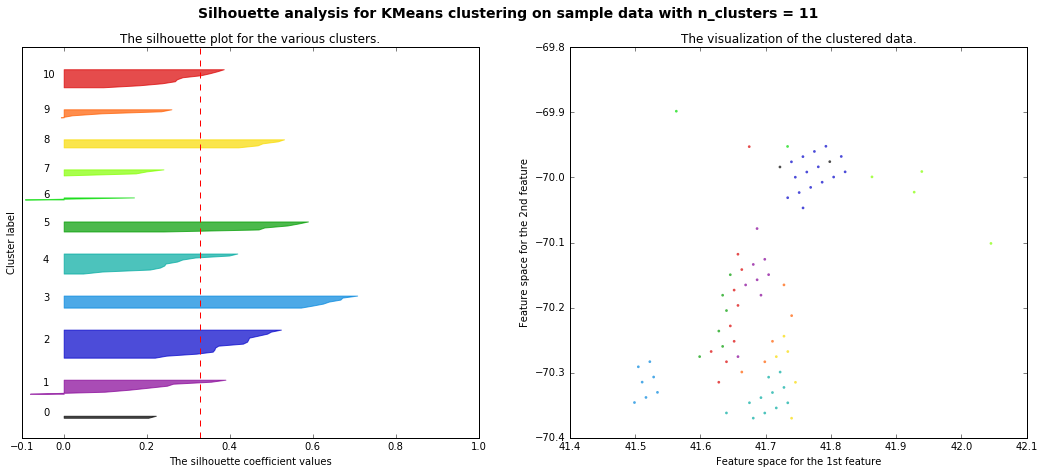

('For n_clusters =', 12, 'The average silhouette_score is :', 0.33241138733335845)


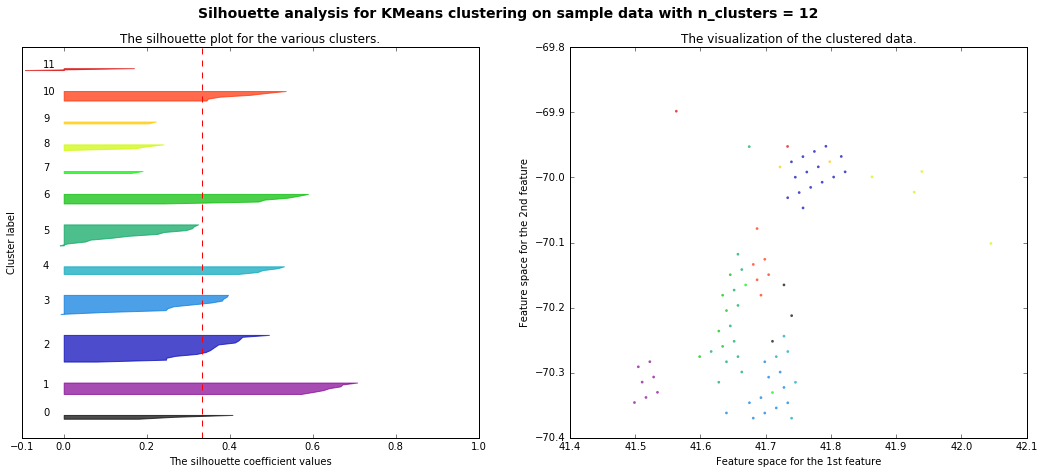

('For n_clusters =', 13, 'The average silhouette_score is :', 0.29855650538990713)


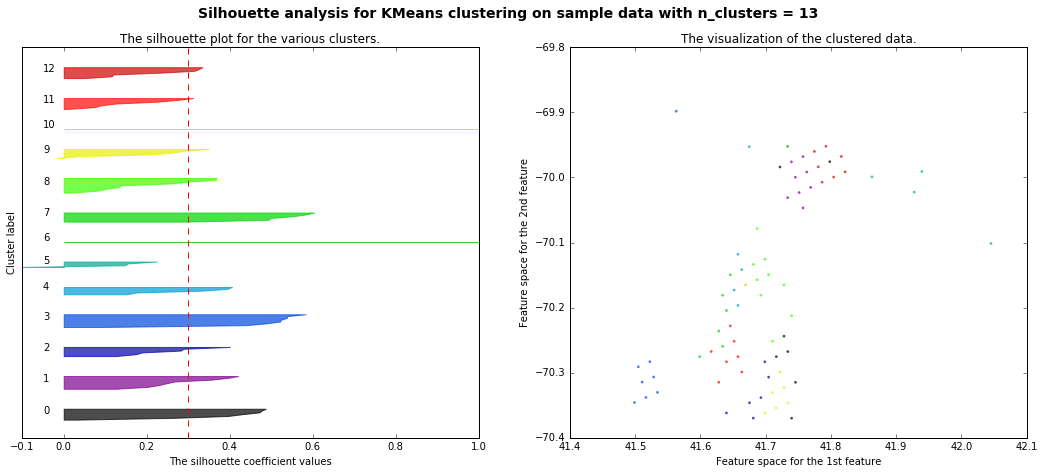

('For n_clusters =', 14, 'The average silhouette_score is :', 0.30600003220748184)


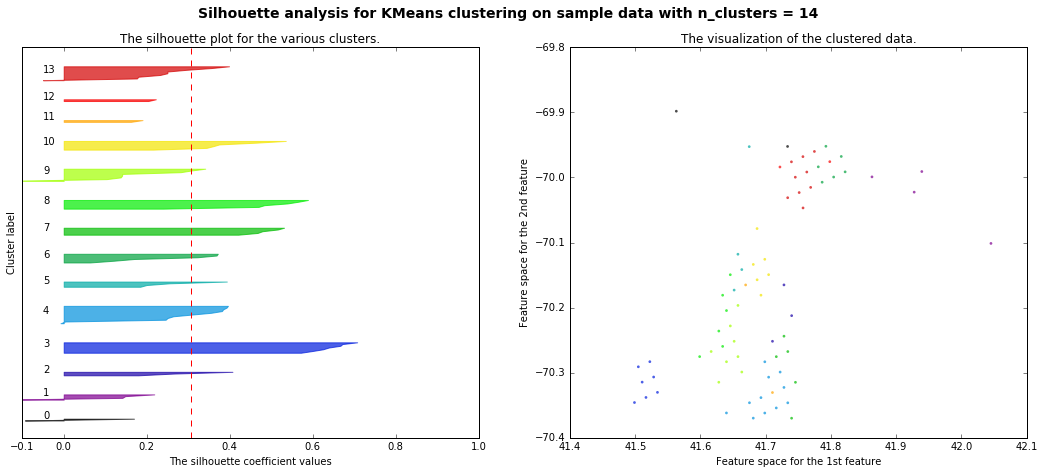

('For n_clusters =', 15, 'The average silhouette_score is :', 0.32439129824178242)


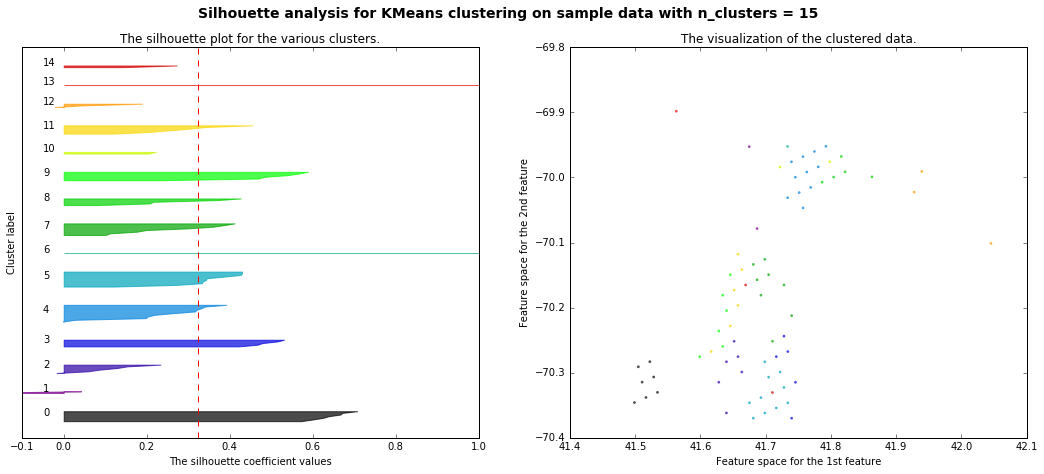

('Optimal n_clusters =', 2, 'The average silhouette_score is :', 0.52965424804538619)


array([ 3,  3,  3,  3,  3,  3,  3,  5,  4, 10, 10, 10,  5,  5,  4,  4,  9,
        1, 10, 10,  5,  5,  6,  4,  4, 10, 10,  5,  4,  4,  4,  9,  1, 10,
       10,  8,  4,  4,  4,  8,  9,  1,  1,  1,  8,  8,  8,  1,  1,  1,  9,
        9, 10,  2,  0,  2,  2,  2,  2,  6,  2,  2,  2,  2,  2,  2,  2,  0,
        2,  2,  2,  7,  7,  7,  7], dtype=int32)

In [5]:
#main(preprocess4, "Easter_Cape_Cod_MA")
capacity_clustering(preprocess4, "Easter_Cape_Cod_MA")

('For n_clusters =', 2, 'The average silhouette_score is :', 0.54599571102154354)


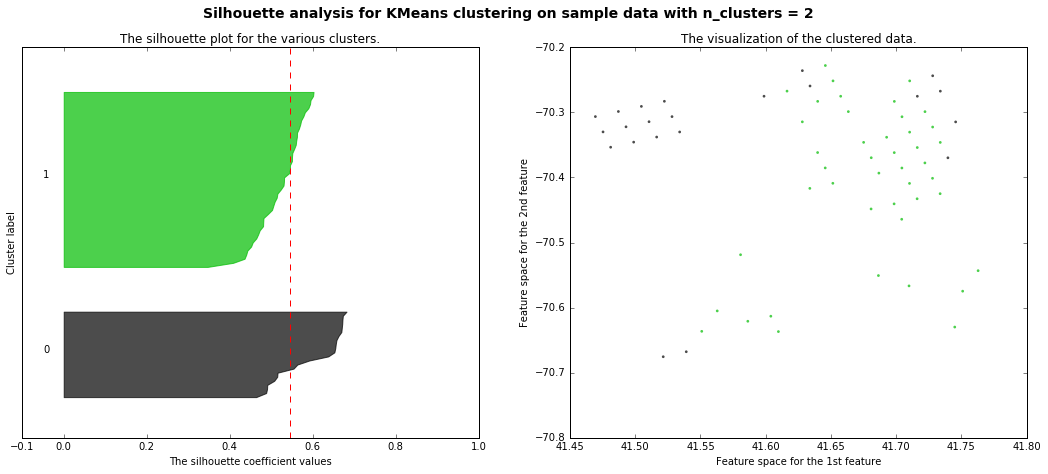

('For n_clusters =', 3, 'The average silhouette_score is :', 0.37103416659445976)


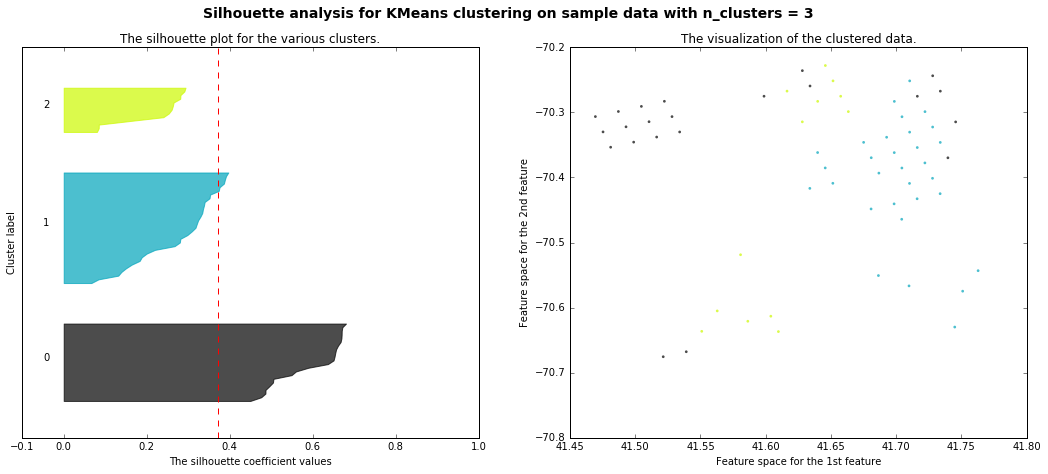

('For n_clusters =', 4, 'The average silhouette_score is :', 0.34448293820624887)


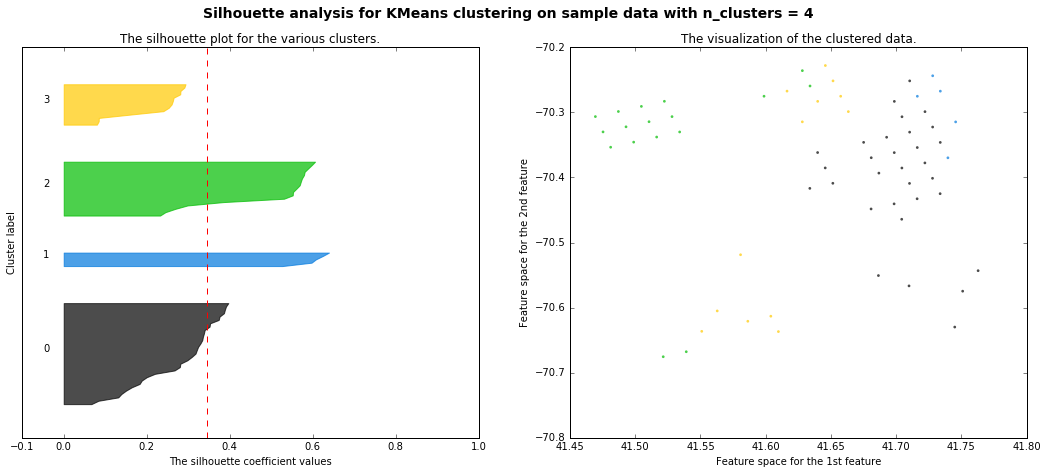

('For n_clusters =', 5, 'The average silhouette_score is :', 0.35857608147374531)


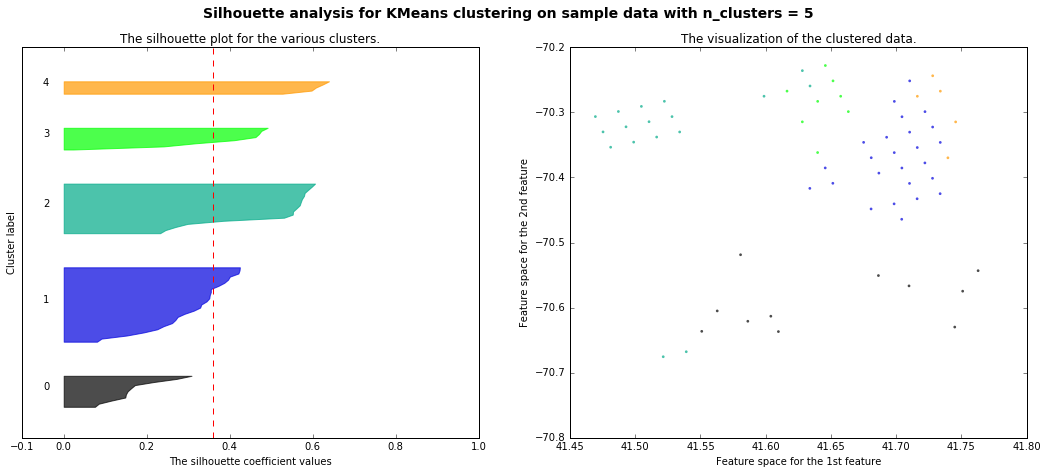

('For n_clusters =', 6, 'The average silhouette_score is :', 0.38541667001584923)


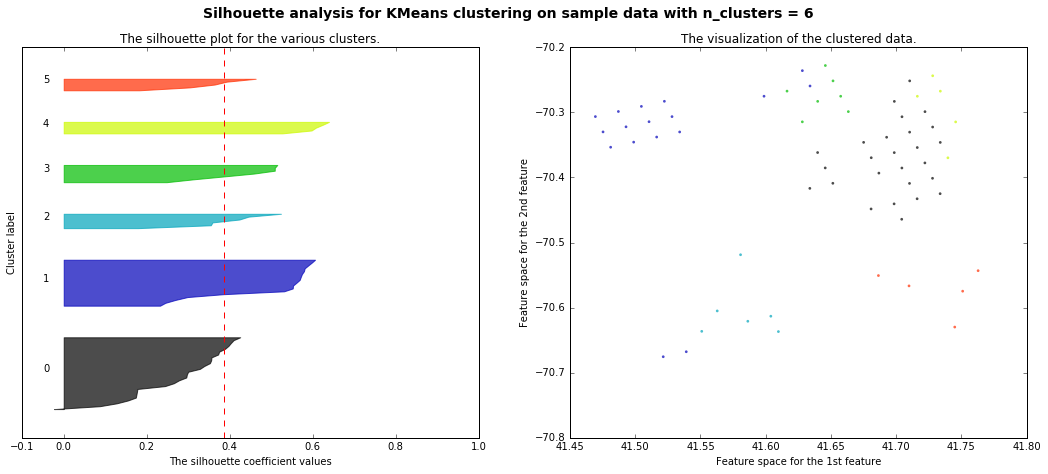

('For n_clusters =', 7, 'The average silhouette_score is :', 0.36238244903469863)


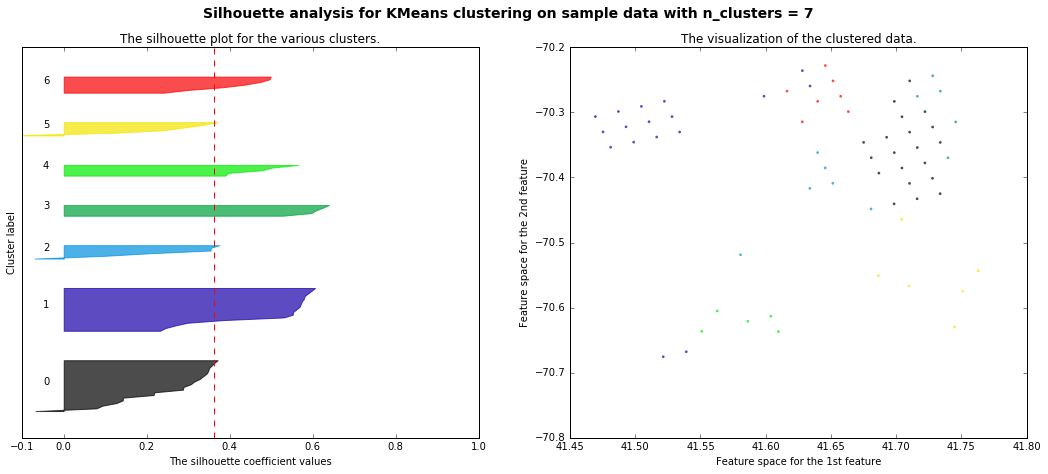

('For n_clusters =', 8, 'The average silhouette_score is :', 0.35526415310597759)


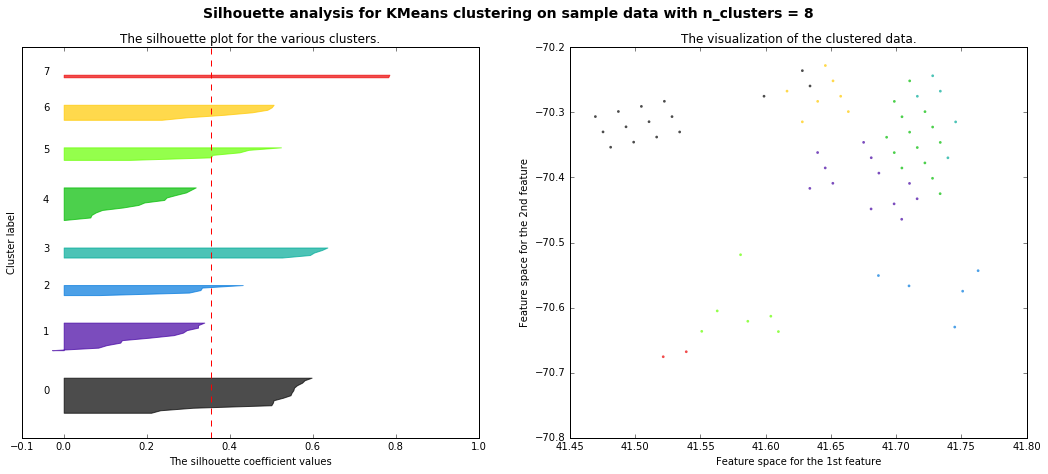

('For n_clusters =', 9, 'The average silhouette_score is :', 0.37491527237444411)


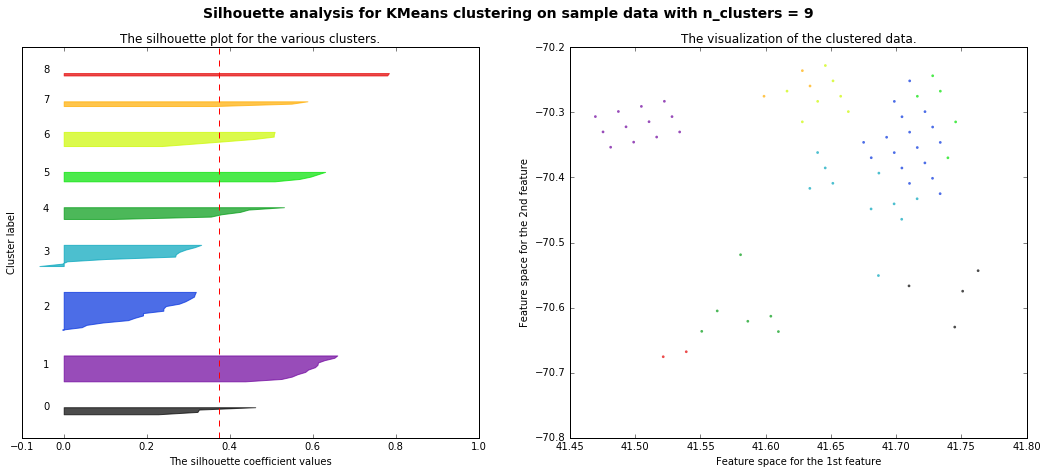

('For n_clusters =', 10, 'The average silhouette_score is :', 0.37984618421636657)


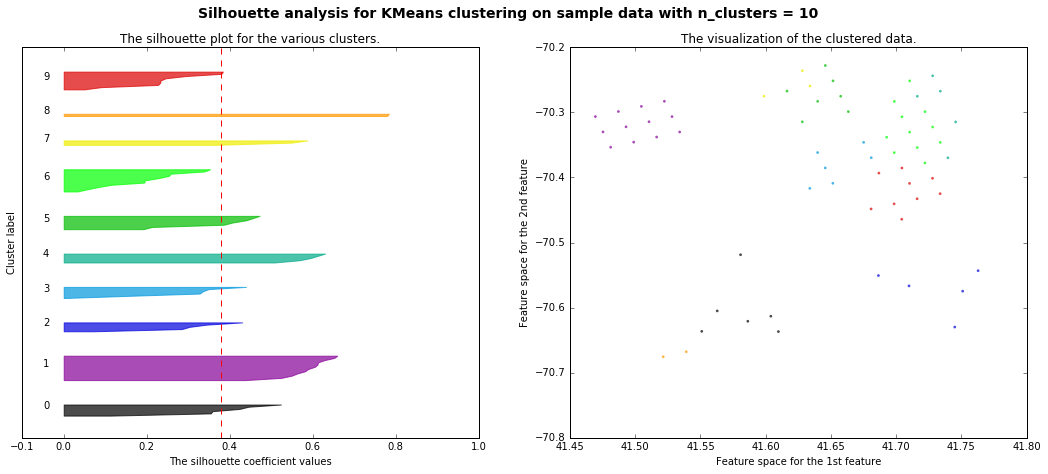

('For n_clusters =', 11, 'The average silhouette_score is :', 0.3801156125904171)


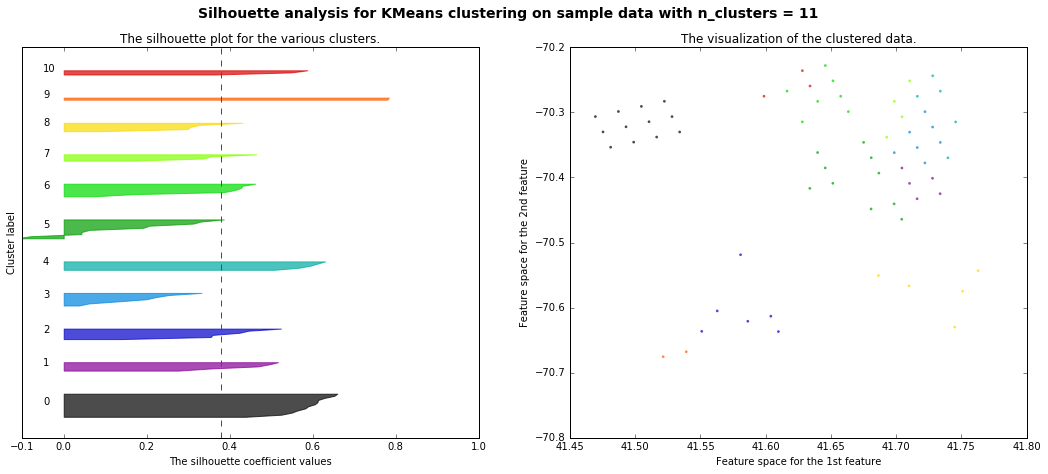

('For n_clusters =', 12, 'The average silhouette_score is :', 0.38439244443844633)


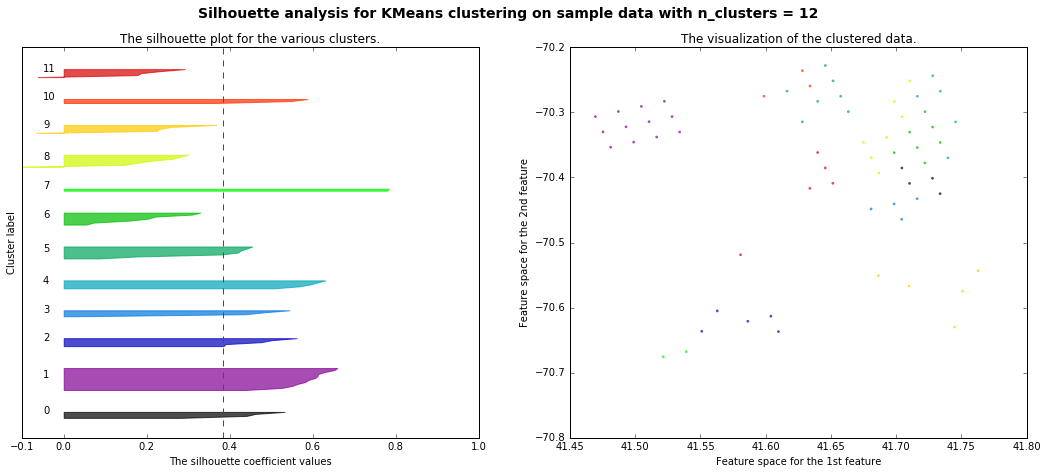

('For n_clusters =', 13, 'The average silhouette_score is :', 0.39686747799859834)


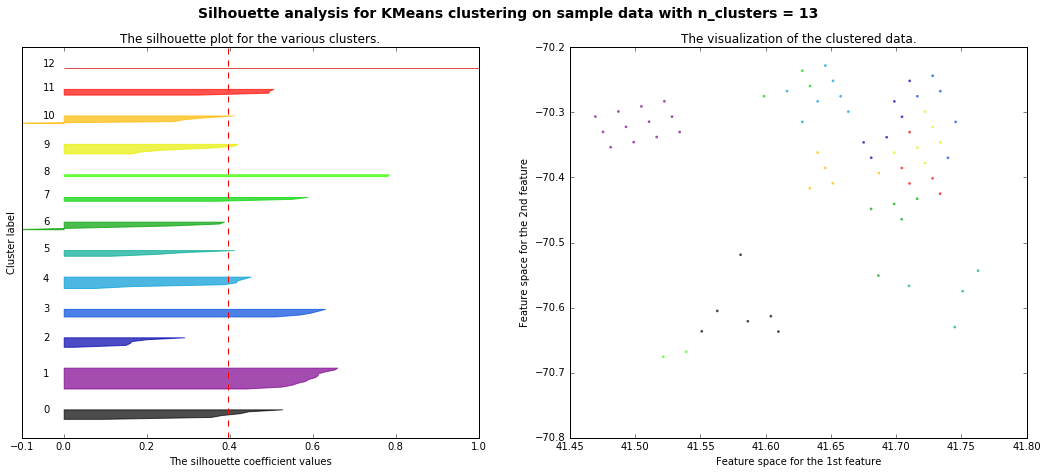

('For n_clusters =', 14, 'The average silhouette_score is :', 0.39547053130196419)


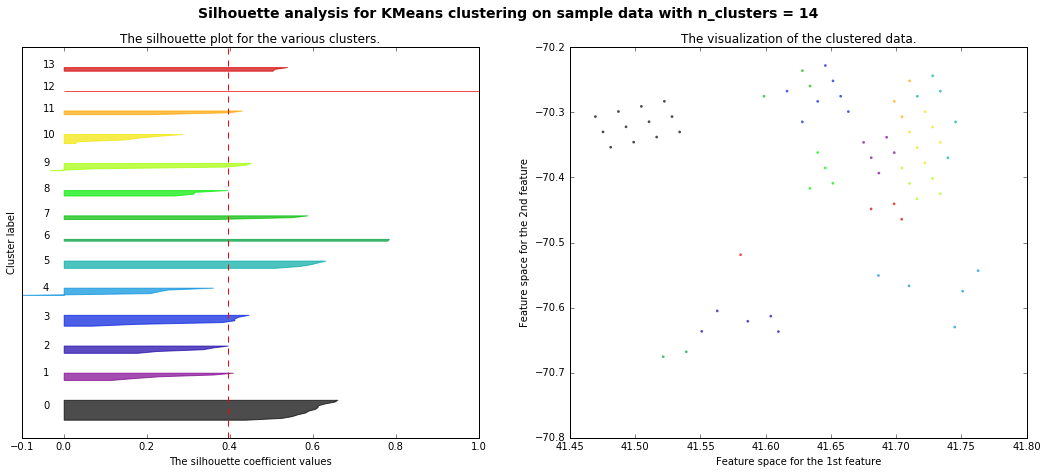

('For n_clusters =', 15, 'The average silhouette_score is :', 0.38770118144102772)


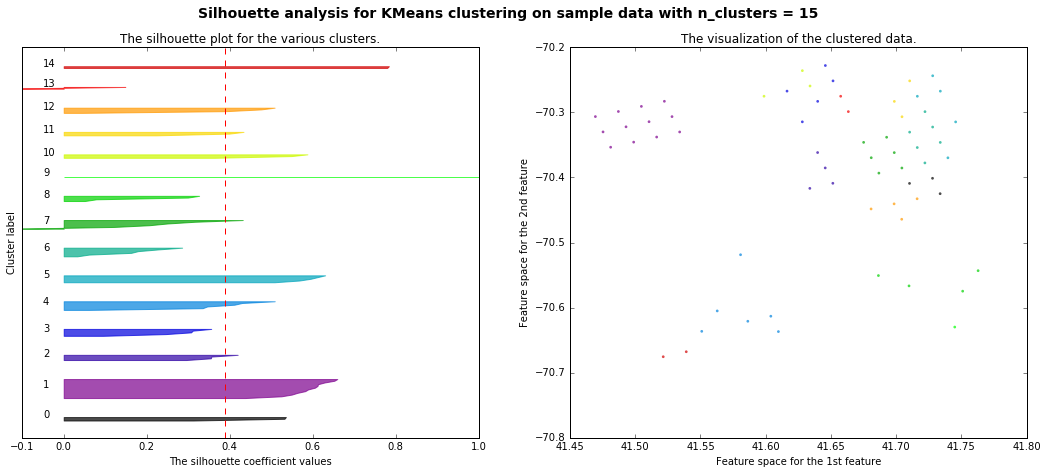

('Optimal n_clusters =', 2, 'The average silhouette_score is :', 0.54599571102154354)


array([ 9,  9,  2,  0,  0,  0,  2,  0,  0,  0,  2,  0,  0,  0,  2,  2,  2,
        0,  0,  0,  5, 10,  8,  5,  5,  5,  6,  6,  8,  5,  6, 10, 10,  8,
        5,  5,  5,  5,  5,  6,  6,  6,  6,  8,  1,  1,  1,  3,  7,  8,  1,
        1,  3,  3,  3,  7,  7,  4,  3,  3,  3,  4,  7,  4,  4,  4], dtype=int32)

In [405]:
#main(preprocess4, "Western_Cape_Cod_MA")
capacity_clustering(preprocess4, "Western_Cape_Cod_MA")

In [372]:
def mean_shift(preprocess_f, path):
    variance_threshold = 0.90
    capacity_positions, capacity_matrix = load_capacity_matrix(preprocess_f, path)
    # Step 2
    optimal_k = PCA_dimension_selection(capacity_matrix, variance_threshold)
    print("The original capacity feature dimension is: ", capacity_matrix.shape[1],
          " The optimal reduced dimension from SVD is: ", optimal_k, 
          " The variance retained is: ", variance_threshold)
    # Step 3
    reduced_design_matrix_positions, reduced_design_matrix, reduced_capacity_matrix = load_PCA_design_matrix(preprocess_f, path, optimal_k)
    # Step 4
    plot(reduced_design_matrix_positions, reduced_design_matrix, visualizeCenter=False)
    

In [3]:
mean_shift(preprocess2, "Easter_Cape_Cod_MA")

NameError: name 'mean_shift' is not defined

In [441]:
#Labels for East
East = [5, 5, 5, 5, 5, 5, 5, 1, 0, 3, 3, 3, 1, 1, 0, 0, 3, 3, 3, 3, 1, 1, 5,
       0, 0, 3, 3, 1, 0, 0, 0, 0, 3, 3, 3, 4, 0, 0, 0, 4, 7, 7, 7, 7, 4, 4,
       4, 7, 7, 7, 7, 7, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2]
#Labels for West
West = [9,  9,  2,  0,  0,  0,  2,  0,  0,  0,  2,  0,  0,  0,  2,  2,  2,
        0,  0,  0,  5, 10,  8,  5,  5,  5,  6,  6,  8,  5,  6, 10, 10,  8,
        5,  5,  5,  5,  5,  6,  6,  6,  6,  8,  1,  1,  1,  3,  7,  8,  1,
        1,  3,  3,  3,  7,  7,  4,  3,  3,  3,  4,  7,  4,  4,  4]

In [439]:
East[60]

2

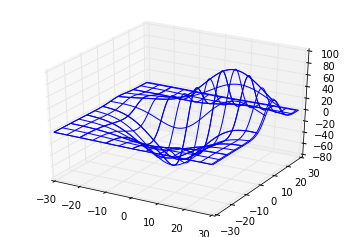

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Grab some test data.
X, Y, Z = axes3d.get_test_data(0.05)

# Plot a basic wireframe.
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)
X, Y, Z = axes3d.get_test_data(0.1)
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

plt.show()

In [6]:
X.shape

(120, 120)

In [7]:
Y.shape

(120, 120)

In [9]:
Z.shape

(120, 120)